In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data/'
batch_size = 512
batch_num  = 128
epoch_num  = 1000
samp_num   = 7

device = torch.device("cuda:0")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t <= 2015}
valid_range = {t: True for t in graph.times if t != None and (t > 2015) & (t < 2018)}
test_range  = {t: True for t in graph.times if t != None and t >= 2018}

In [4]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), batch_size, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], batch_size)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'field': fids}, sampled_depth = 4, sampled_number = 128)

    el = []
    for i in edge_list['paper']['field']['rev_PF_in']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['field']['rev_PF_in'] = el

    el = []
    for i in edge_list['field']['paper']['PF_in']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['field']['paper']['PF_in'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list)
    '''
        Trace the paper_id and field_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    field_ids = np.arange(len(fids)) + node_dict['field'][0]
    ylabel = torch.zeros(batch_size, len(ids))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][list(ids).index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [10]:
class RGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_relations, num_bases, device, **kwargs):
        super(RGCNConv, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.device = device
        
        self.basis = nn.Parameter(torch.Tensor(num_bases, in_channels, out_channels))
        self.att   = nn.Parameter(torch.Tensor(num_relations, num_bases))
        self.root  = nn.Linear(in_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        size = self.num_bases * self.in_channels
        uniform(size, self.basis)
        uniform(size, self.att)


    def forward(self, x, edge_index, edge_type):
        """"""
        return self.propagate(edge_index, x=x, edge_type=edge_type)


    def message(self, x_j, edge_index_j, edge_type, edge_norm):
        ws = torch.matmul(self.att, self.basis.view(self.num_bases, -1))
        ws = ws.view(self.num_relations, self.in_channels, self.out_channels)
        data_size = edge_index_j.size(0)
        res = torch.zeros(data_size, self.out_channels).to(self.device)
        
        for r_id in range(self.num_relations):
            w   = ws[r_id]
            idx = (edge_type == r_id)
            if idx.sum() == 0:
                continue
            batch_x_j = x_j[idx]
            res[idx] = torch.mm(batch_x_j, w).squeeze(-2)
        return res

    def update(self, aggr_out):
        return aggr_out

    def __repr__(self):
        return '{}({}, {}, num_relations={})'.format(
            self.__class__.__name__, self.in_channels, self.out_channels,
            self.num_relations)

In [6]:
class GNN(nn.Module):
    def __init__(self, n_hid, n_layers, num_relations, device, dropout = 0.5):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.n_hid = n_hid
        self.adapt = nn.Linear(n_hid, n_hid // 2)
        self.drop  = nn.Dropout(dropout)
        for l in range(n_layers):
            self.gcs.append(RGCNConv(n_hid // 2, n_hid // 2, num_relations, int(math.sqrt(n_hid)), device))
    def set_device(self, device):
        self.device = device
        for gc in self.gcs:
            gc.device = device
    def forward(self, node_feature, edge_index, edge_type):
        meta_xs = self.drop(F.elu(self.adapt(node_feature)))
        for gc in self.gcs:
            meta_xs = self.drop(gc(meta_xs, edge_index, edge_type))
        return meta_xs
    def __repr__(self):
        return '{}(n_hid={}, n_layers={})'.format(
            self.__class__.__name__, self.n_hid, len(self.gcs))

In [7]:
'''
Paper-Field
'''
field_dict = dill.load(open(data_dir + 'field_dict.pk', 'rb'))
ids = np.array([graph.node_forward['field'][k] for k in field_dict if field_dict[k][0] == 'L1'])

paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in ids:
    for p_id in graph.edge_list['field']['paper']['PF_in'][f_id]:
        _time = graph.edge_list['field']['paper']['PF_in'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [13]:
gnn = GNN(400, n_layers = 2, num_relations = len(graph.get_meta_graph()) + 1, device = device).to(device)
classifier = Classifier(200, len(ids)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 2000, eta_min=0)

In [14]:
stats = []
pool = mp.Pool(8)
process_ids = np.arange(batch_num // 8)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 2500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(8)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    
    model.train()
    train_losses = []
    for batch in np.arange(8):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), edge_index.to(device), edge_type.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), edge_index.to(device), edge_type.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/rgcn.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
            res = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print(test_ndcg)
    del train_data, valid_data

Data Preparation: 89.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (75.6s)  LR: 0.00022 Train Loss: 3.91  Valid Loss: 4.48  Valid NDCG: 0.4821
Data Preparation: 24.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (76.8s)  LR: 0.00030 Train Loss: 3.45  Valid Loss: 4.43  Valid NDCG: 0.5090
Data Preparation: 28.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 3 (72.1s)  LR: 0.00039 Train Loss: 3.22  Valid Loss: 3.48  Valid NDCG: 0.6111
Data Preparation: 25.4s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 4 (70.7s)  LR: 0.00048 Train Loss: 2.57  Valid Loss: 3.01  Valid NDCG: 0.6644
Data Preparation: 26.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 5 (80.1s)  LR: 0.00058 Train Loss: 2.20  Valid Loss: 2.20  Valid NDCG: 0.7179
0.6570521721886435
Data Preparation: 28.6s
Epoch: 6 (73.5s)  LR: 0.00067 Train Loss: 2.32  Valid Loss: 2.50  Valid NDCG: 0.6770
Data Preparation: 27.0s
Epoch: 7 (71.4s)  LR: 0.00075 Train Loss: 2.04  Valid Loss: 2.31  Valid NDCG: 0.7089
Data Preparation: 23.6s
Epoch: 8 (69.6s)  LR: 0.00083 Train Loss: 1.81  Valid Loss: 2.56  Valid NDCG: 0.6810
Data Preparation: 28.6s
Epoch: 9 (69.8s)  LR: 0.00090 Train Loss: 2.33  Valid Loss: 2.27  Valid NDCG: 0.6927
Data Preparation: 22.7s
Epoch: 10 (68.1s)  LR: 0.00095 Train Loss: 1.77  Valid Loss: 2.39  Valid NDCG: 0.6758
0.6504779980684388
Data Preparation: 29.9s
Epoch: 11 (70.7s)  LR: 0.00098 Train Loss: 1.79  Valid Loss: 2.20  Valid NDCG: 0.7055
Data Preparation: 25.1s
Epoch: 12 (68.5s)  LR: 0.00100 Train Loss: 1.70  Valid Loss: 2.40  Valid NDCG: 0.6902
Data Preparation: 27.7s
Epoch: 13 (69.1s)  LR: 0.00100 Train Loss: 1.64  Valid Loss: 2.52  Valid NDCG: 0.6595
D

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 15 (77.2s)  LR: 0.00095 Train Loss: 1.61  Valid Loss: 1.96  Valid NDCG: 0.7611
0.6752642900499453
Data Preparation: 28.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 16 (73.0s)  LR: 0.00090 Train Loss: 1.65  Valid Loss: 1.96  Valid NDCG: 0.7742
Data Preparation: 29.0s
Epoch: 17 (73.0s)  LR: 0.00083 Train Loss: 1.81  Valid Loss: 2.34  Valid NDCG: 0.6806
Data Preparation: 22.7s
Epoch: 18 (73.9s)  LR: 0.00075 Train Loss: 1.64  Valid Loss: 2.09  Valid NDCG: 0.7336
Data Preparation: 19.7s
Epoch: 19 (75.3s)  LR: 0.00067 Train Loss: 1.56  Valid Loss: 2.15  Valid NDCG: 0.7219
Data Preparation: 28.4s
Epoch: 20 (75.5s)  LR: 0.00058 Train Loss: 1.59  Valid Loss: 2.36  Valid NDCG: 0.6839
0.7375441750777545
Data Preparation: 29.5s
Epoch: 21 (71.4s)  LR: 0.00048 Train Loss: 1.50  Valid Loss: 2.13  Valid NDCG: 0.7257
Data Preparation: 28.9s
Epoch: 22 (74.2s)  LR: 0.00039 Train Loss: 1.49  Valid Loss: 2.13  Valid NDCG: 0.7422
Data Preparation: 20.9s
Epoch: 23 (74.9s)  LR: 0.00030 Train Loss: 1.42  Valid Loss: 2.14  Valid NDCG: 0.7222
Data Preparation: 27.7s
Epoch: 24 (69.4s)  LR: 0.00022 Train Loss: 1.45  Valid Loss: 1.92  Valid NDCG: 0.7507
Data Preparatio

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 31 (76.5s)  LR: 0.00003 Train Loss: 1.45  Valid Loss: 1.95  Valid NDCG: 0.7764
Data Preparation: 27.8s
Epoch: 32 (75.6s)  LR: 0.00007 Train Loss: 1.48  Valid Loss: 2.09  Valid NDCG: 0.7373
Data Preparation: 25.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 33 (75.7s)  LR: 0.00012 Train Loss: 1.45  Valid Loss: 1.83  Valid NDCG: 0.7916
Data Preparation: 26.7s
Epoch: 34 (78.4s)  LR: 0.00019 Train Loss: 1.52  Valid Loss: 1.89  Valid NDCG: 0.7695
Data Preparation: 25.0s
Epoch: 35 (80.1s)  LR: 0.00027 Train Loss: 1.49  Valid Loss: 2.07  Valid NDCG: 0.7394
0.7226416039316468
Data Preparation: 30.2s
Epoch: 36 (75.7s)  LR: 0.00036 Train Loss: 1.56  Valid Loss: 2.08  Valid NDCG: 0.7311
Data Preparation: 28.8s
Epoch: 37 (74.0s)  LR: 0.00045 Train Loss: 1.50  Valid Loss: 2.23  Valid NDCG: 0.7276
Data Preparation: 23.9s
Epoch: 38 (74.4s)  LR: 0.00055 Train Loss: 1.45  Valid Loss: 1.89  Valid NDCG: 0.7681
Data Preparation: 31.9s
Epoch: 39 (82.4s)  LR: 0.00064 Train Loss: 2.00  Valid Loss: 2.29  Valid NDCG: 0.7332
Data Preparation: 26.3s
Epoch: 40 (77.1s)  LR: 0.00073 Train Loss: 1.64  Valid Loss: 1.97  Valid NDCG: 0.7672
0.6943810237312646
Data Preparation: 30.2s
Epoch: 41 (72.5s)  LR: 0.00081 Train Loss: 1.51  Valid Loss: 2.29  Valid NDCG: 0.7

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 57 (80.3s)  LR: 0.00025 Train Loss: 1.36  Valid Loss: 1.67  Valid NDCG: 0.8020
Data Preparation: 27.4s
Epoch: 58 (78.5s)  LR: 0.00017 Train Loss: 1.41  Valid Loss: 1.88  Valid NDCG: 0.7716
Data Preparation: 24.8s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 59 (72.0s)  LR: 0.00010 Train Loss: 1.38  Valid Loss: 1.69  Valid NDCG: 0.8112
Data Preparation: 27.2s
Epoch: 60 (76.5s)  LR: 0.00005 Train Loss: 1.36  Valid Loss: 1.84  Valid NDCG: 0.7774
0.7356713075389307
Data Preparation: 29.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 61 (83.3s)  LR: 0.00002 Train Loss: 1.42  Valid Loss: 1.59  Valid NDCG: 0.8221
Data Preparation: 27.2s
Epoch: 62 (76.9s)  LR: 0.00000 Train Loss: 1.39  Valid Loss: 1.79  Valid NDCG: 0.7957
Data Preparation: 29.1s
Epoch: 63 (74.0s)  LR: 0.00000 Train Loss: 1.39  Valid Loss: 1.95  Valid NDCG: 0.7691
Data Preparation: 31.2s
Epoch: 64 (77.2s)  LR: 0.00002 Train Loss: 1.40  Valid Loss: 1.77  Valid NDCG: 0.7889
Data Preparation: 26.8s
Epoch: 65 (79.3s)  LR: 0.00005 Train Loss: 1.35  Valid Loss: 1.93  Valid NDCG: 0.7466
0.6912328152873801
Data Preparation: 28.5s
Epoch: 66 (80.1s)  LR: 0.00010 Train Loss: 1.39  Valid Loss: 1.87  Valid NDCG: 0.7742
Data Preparation: 30.8s
Epoch: 67 (78.3s)  LR: 0.00017 Train Loss: 1.39  Valid Loss: 1.93  Valid NDCG: 0.7596
Data Preparation: 25.8s
Epoch: 68 (71.4s)  LR: 0.00025 Train Loss: 1.40  Valid Loss: 1.84  Valid NDCG: 0.7715
Data Preparation: 31.3s
Epoch: 69 (78.1s)  LR: 0.00033 Train Loss: 1.41  Valid Loss: 1.81  Valid NDCG: 0.7939
Data Preparatio

Data Preparation: 29.1s
Epoch: 133 (73.3s)  LR: 0.00012 Train Loss: 1.50  Valid Loss: 1.69  Valid NDCG: 0.7903
Data Preparation: 24.5s
Epoch: 134 (76.7s)  LR: 0.00019 Train Loss: 1.56  Valid Loss: 1.93  Valid NDCG: 0.7504
Data Preparation: 29.5s
Epoch: 135 (84.1s)  LR: 0.00027 Train Loss: 1.57  Valid Loss: 1.75  Valid NDCG: 0.7989
0.6891143313247338
Data Preparation: 28.8s
Epoch: 136 (82.7s)  LR: 0.00036 Train Loss: 1.55  Valid Loss: 1.82  Valid NDCG: 0.7651
Data Preparation: 23.7s
Epoch: 137 (76.2s)  LR: 0.00045 Train Loss: 1.49  Valid Loss: 1.78  Valid NDCG: 0.7836
Data Preparation: 27.6s
Epoch: 138 (71.5s)  LR: 0.00055 Train Loss: 1.48  Valid Loss: 1.88  Valid NDCG: 0.7668
Data Preparation: 27.8s
Epoch: 139 (77.7s)  LR: 0.00064 Train Loss: 1.47  Valid Loss: 1.80  Valid NDCG: 0.7669
Data Preparation: 26.1s
Epoch: 140 (81.3s)  LR: 0.00073 Train Loss: 1.51  Valid Loss: 1.79  Valid NDCG: 0.7811
0.6900471283739705
Data Preparation: 29.5s
Epoch: 141 (75.7s)  LR: 0.00081 Train Loss: 1.50  

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 190 (70.0s)  LR: 0.00027 Train Loss: 1.36  Valid Loss: 1.46  Valid NDCG: 0.8308
0.7327216455876273
Data Preparation: 29.1s
Epoch: 191 (70.2s)  LR: 0.00019 Train Loss: 1.26  Valid Loss: 1.59  Valid NDCG: 0.7983
Data Preparation: 29.0s
Epoch: 192 (68.8s)  LR: 0.00012 Train Loss: 1.28  Valid Loss: 1.51  Valid NDCG: 0.8122
Data Preparation: 27.8s
Epoch: 193 (70.7s)  LR: 0.00007 Train Loss: 1.28  Valid Loss: 1.49  Valid NDCG: 0.8115
Data Preparation: 26.2s
Epoch: 194 (70.1s)  LR: 0.00003 Train Loss: 1.38  Valid Loss: 1.68  Valid NDCG: 0.7831
Data Preparation: 26.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 195 (69.0s)  LR: 0.00001 Train Loss: 1.37  Valid Loss: 1.45  Valid NDCG: 0.8315
0.7551308707431115
Data Preparation: 31.9s
Epoch: 196 (75.4s)  LR: 0.00000 Train Loss: 1.37  Valid Loss: 1.66  Valid NDCG: 0.7797
Data Preparation: 20.4s
Epoch: 197 (69.4s)  LR: 0.00001 Train Loss: 1.37  Valid Loss: 1.65  Valid NDCG: 0.7939
Data Preparation: 29.5s
Epoch: 198 (70.0s)  LR: 0.00004 Train Loss: 1.26  Valid Loss: 1.49  Valid NDCG: 0.8172
Data Preparation: 29.7s
Epoch: 199 (69.2s)  LR: 0.00009 Train Loss: 1.30  Valid Loss: 1.60  Valid NDCG: 0.7980
Data Preparation: 25.0s
Epoch: 200 (71.5s)  LR: 0.00015 Train Loss: 1.33  Valid Loss: 1.42  Valid NDCG: 0.8280
0.7691542190576739
Data Preparation: 29.5s
Epoch: 201 (68.0s)  LR: 0.00022 Train Loss: 1.27  Valid Loss: 1.53  Valid NDCG: 0.8163
Data Preparation: 28.0s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 202 (68.3s)  LR: 0.00030 Train Loss: 1.34  Valid Loss: 1.50  Valid NDCG: 0.8316
Data Preparation: 28.9s
Epoch: 203 (71.3s)  LR: 0.00039 Train Loss: 1.35  Valid Loss: 1.59  Valid NDCG: 0.8108
Data Preparation: 25.6s
Epoch: 204 (71.7s)  LR: 0.00048 Train Loss: 1.37  Valid Loss: 1.70  Valid NDCG: 0.7794
Data Preparation: 23.5s
Epoch: 205 (69.1s)  LR: 0.00058 Train Loss: 1.37  Valid Loss: 1.57  Valid NDCG: 0.7980
0.7731376533056254
Data Preparation: 30.7s
Epoch: 206 (72.2s)  LR: 0.00067 Train Loss: 1.40  Valid Loss: 1.55  Valid NDCG: 0.8012
Data Preparation: 27.5s
Epoch: 207 (71.4s)  LR: 0.00075 Train Loss: 1.47  Valid Loss: 1.58  Valid NDCG: 0.8028
Data Preparation: 26.5s
Epoch: 208 (69.5s)  LR: 0.00083 Train Loss: 1.47  Valid Loss: 1.54  Valid NDCG: 0.8039
Data Preparation: 23.6s
Epoch: 209 (70.2s)  LR: 0.00090 Train Loss: 1.38  Valid Loss: 1.71  Valid NDCG: 0.7668
Data Preparation: 33.2s
Epoch: 210 (71.7s)  LR: 0.00095 Train Loss: 1.46  Valid Loss: 1.62  Valid NDCG: 0.7898
0.7374

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 239 (67.0s)  LR: 0.00064 Train Loss: 1.33  Valid Loss: 1.30  Valid NDCG: 0.8467
Data Preparation: 30.2s
Epoch: 240 (76.7s)  LR: 0.00073 Train Loss: 1.42  Valid Loss: 1.53  Valid NDCG: 0.8038
0.7879822776326272
Data Preparation: 29.7s
Epoch: 241 (71.9s)  LR: 0.00081 Train Loss: 1.41  Valid Loss: 1.54  Valid NDCG: 0.8024
Data Preparation: 29.1s
Epoch: 242 (73.3s)  LR: 0.00088 Train Loss: 1.41  Valid Loss: 1.74  Valid NDCG: 0.7724
Data Preparation: 27.6s
Epoch: 243 (71.1s)  LR: 0.00093 Train Loss: 1.37  Valid Loss: 1.56  Valid NDCG: 0.7985
Data Preparation: 26.6s
Epoch: 244 (70.6s)  LR: 0.00097 Train Loss: 1.34  Valid Loss: 1.59  Valid NDCG: 0.7936
Data Preparation: 27.9s
Epoch: 245 (75.7s)  LR: 0.00099 Train Loss: 1.45  Valid Loss: 1.71  Valid NDCG: 0.7705
0.7270293278660179
Data Preparation: 28.9s
Epoch: 246 (72.6s)  LR: 0.00100 Train Loss: 1.40  Valid Loss: 1.69  Valid NDCG: 0.7762
Data Preparation: 22.9s
Epoch: 247 (69.5s)  LR: 0.00099 Train Loss: 1.38  Valid Loss: 1.50  Valid 

0.786277403588793
Data Preparation: 51.1s
Epoch: 311 (73.2s)  LR: 0.00098 Train Loss: 1.35  Valid Loss: 1.62  Valid NDCG: 0.7982
Data Preparation: 51.0s
Epoch: 312 (72.1s)  LR: 0.00100 Train Loss: 1.33  Valid Loss: 1.44  Valid NDCG: 0.8225
Data Preparation: 48.6s
Epoch: 313 (73.5s)  LR: 0.00100 Train Loss: 1.38  Valid Loss: 1.53  Valid NDCG: 0.8120
Data Preparation: 46.8s
Epoch: 314 (74.1s)  LR: 0.00098 Train Loss: 1.40  Valid Loss: 1.44  Valid NDCG: 0.8241
Data Preparation: 47.5s
Epoch: 315 (71.3s)  LR: 0.00095 Train Loss: 1.40  Valid Loss: 1.51  Valid NDCG: 0.8115
0.7736641617166224
Data Preparation: 55.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type RGCNConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 316 (73.1s)  LR: 0.00090 Train Loss: 1.37  Valid Loss: 1.23  Valid NDCG: 0.8622
Data Preparation: 49.6s
Epoch: 317 (73.4s)  LR: 0.00083 Train Loss: 1.39  Valid Loss: 1.58  Valid NDCG: 0.7956
Data Preparation: 50.3s
Epoch: 318 (72.4s)  LR: 0.00075 Train Loss: 1.32  Valid Loss: 1.50  Valid NDCG: 0.8097
Data Preparation: 50.0s
Epoch: 319 (70.4s)  LR: 0.00067 Train Loss: 1.99  Valid Loss: 1.56  Valid NDCG: 0.8028
Data Preparation: 51.0s
Epoch: 320 (72.7s)  LR: 0.00058 Train Loss: 1.43  Valid Loss: 1.47  Valid NDCG: 0.8222
0.7400516935548698
Data Preparation: 52.7s
Epoch: 321 (72.4s)  LR: 0.00048 Train Loss: 1.38  Valid Loss: 1.37  Valid NDCG: 0.8432
Data Preparation: 50.8s
Epoch: 322 (70.7s)  LR: 0.00039 Train Loss: 1.30  Valid Loss: 1.48  Valid NDCG: 0.8287
Data Preparation: 55.7s
Epoch: 323 (75.6s)  LR: 0.00030 Train Loss: 1.35  Valid Loss: 1.48  Valid NDCG: 0.8268
Data Preparation: 50.2s
Epoch: 324 (72.6s)  LR: 0.00022 Train Loss: 1.35  Valid Loss: 1.39  Valid NDCG: 0.8205
Data P

Data Preparation: 52.4s
Epoch: 388 (72.6s)  LR: 0.00045 Train Loss: 1.39  Valid Loss: 1.53  Valid NDCG: 0.7967
Data Preparation: 49.7s
Epoch: 389 (72.0s)  LR: 0.00036 Train Loss: 1.34  Valid Loss: 1.35  Valid NDCG: 0.8332
Data Preparation: 54.4s
Epoch: 390 (72.0s)  LR: 0.00027 Train Loss: 1.34  Valid Loss: 1.50  Valid NDCG: 0.8183
0.7319469278903019
Data Preparation: 54.4s
Epoch: 391 (75.8s)  LR: 0.00019 Train Loss: 1.32  Valid Loss: 1.40  Valid NDCG: 0.8228


Process ForkPoolWorker-3344:
Process ForkPoolWorker-3342:
Process ForkPoolWorker-3339:


KeyboardInterrupt: 

Process ForkPoolWorker-3340:
Process ForkPoolWorker-3343:
Process ForkPoolWorker-3341:
Process ForkPoolWorker-3338:
Process ForkPoolWorker-3337:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ziniu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ziniu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ziniu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ziniu/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ziniu/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call

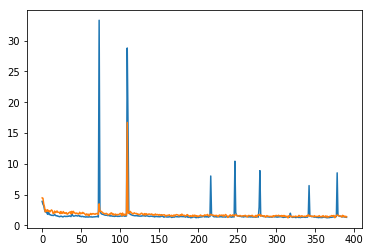

In [15]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [16]:
best_model = torch.load('./save/rgcn.pt')

In [17]:
best_model.eval()
gnn, classifier = best_model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), edge_index.to(device), edge_type.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.7532831683622845 0.06120572204416289
0.7221447213350138 0.12264175751145479
